In [1]:

import warnings
import os
os.environ['PROJ_LIB'] = '/Users/trondkr/anaconda3/envs/cmip6/share/proj'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

warnings.filterwarnings('ignore')
plt.style.use('default')
import os, sys
from shapely.geometry import mapping
import geopandas as gpd
import texttable

sys.path.append("../CMIP6-downscale/")
from CMIP6_ridgeplot import CMIP6_ridgeplot
from xclim import ensembles
from datetime import datetime
import seaborn as sns

import pyproj
pyproj.datadir.set_data_dir('/Users/trondkr/anaconda3/envs/cmip6/share/proj')
pyproj.datadir.get_data_dir()

'/Users/trondkr/anaconda3/envs/cmip6/share/proj'

Plot chlorophyll as either monthly distributions per time periods (e.g. 1993-2010), or plot heatmaps showing the difference in cumulative chlorophyll for an area per month and how the values change into the future. This script is specifically made for plotting mismatch of abundance of chlorophyll.

FRA to SFO 26.10.2022


In [2]:
def convert_to_180(ds):
    ds = ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(lon=(((ds.x + 180) % 360) - 180))).sortby('lon')


def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:
        time_objects = ds.indexes['time'].to_datetimeindex()
        ds = ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds


def get_area_averaged_ds(fname, model, scenario, ensemble_id, var_name, LME, models_dict):
    if os.path.exists(fname):
        ds = xr.open_dataset(fname)
        ds = convert_to_180(ds)

        ds = ds.sel(time=slice(start_time, end_time))
        ds = convert_time(ds)

        # Convert from kg/m-3 to mg/m-3
        if var_name=="chl":
            ds[var_name] = ds[var_name] * 1.0e6
        ds_lme = get_data_within_LME(ds, LME)

        model_info = {}
        model_info["model_name"] = model
        model_info["model_scenario"] = scenario
        model_info["model_ensemble_id"] = ensemble_id
        model_info["model_var"] = var_name
        model_info["LME"] = LME
        key = "{}_{}_{}_{}".format(model, ensemble_id, scenario, var_name)
        models_dict[key] = model_info
        return models_dict, ds_lme
    else:
        return models_dict, None

In [3]:
def get_LME_records():
    lme_file = '/Users/trondkr/Dropbox/NIVA/oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)


def get_LME_records_plot():
    lme_file = '/Users/trondkr/Dropbox/NIVA/oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)


def get_data_within_LME(ds, LME):
    print("Working on LME: {}".format(LME))

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[shdf['LME_NAME'] == LME]

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    tos = ds.rename({'lon': 'x', 'lat': 'y'})
    tos = tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped = clipped.rename({'x': 'lon', 'y': 'lat'})

    return clipped

In [4]:
def create_summary_table(dict_of_models, LME):
    table = texttable.Texttable()
    table.set_cols_align(["c", "c", "c", "c", "c", "c", "c"])
    table.set_cols_valign(["t", "t", "m", "m", "m", "m", "b"])

    table.header(["LME", "Model", "Scenario", "ID", "Var", "CMIP6 min", "CMIP6 max"])
    for key in dict_of_models.keys():
        model = dict_of_models[key]

        table.add_row([LME,
                       model["model_name"],
                       model["model_scenario"],
                       model["model_ensemble_id"],
                       str(model["model_var"]),
                       str(model["model_var"]),
                       str(model["model_var"])])

    table.set_cols_width([30, 30, 20, 20, 10, 10, 10])
    print(table.draw() + "\n")

Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea


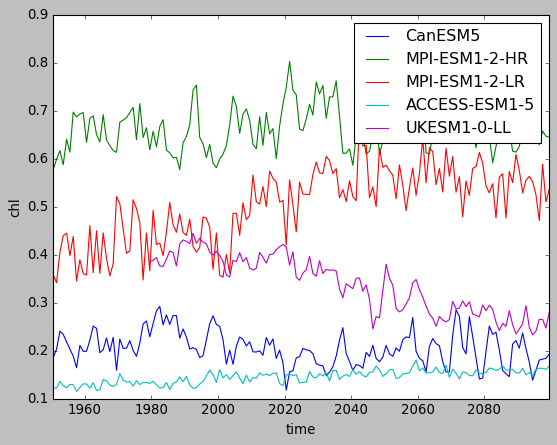

Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea
Working on LME: Barents Sea


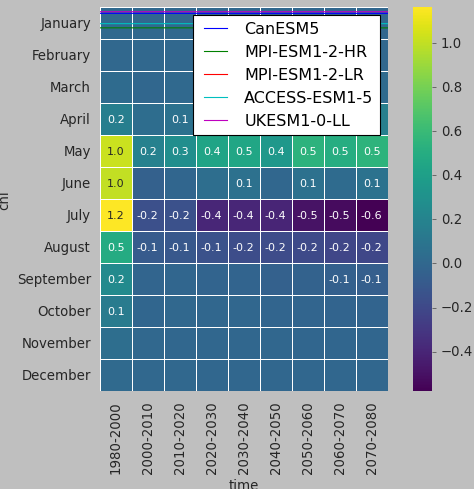

Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas


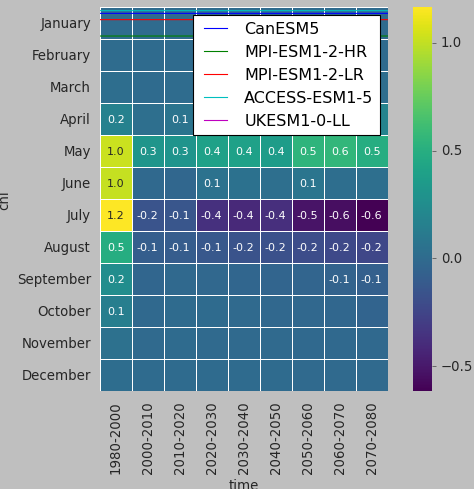

Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas


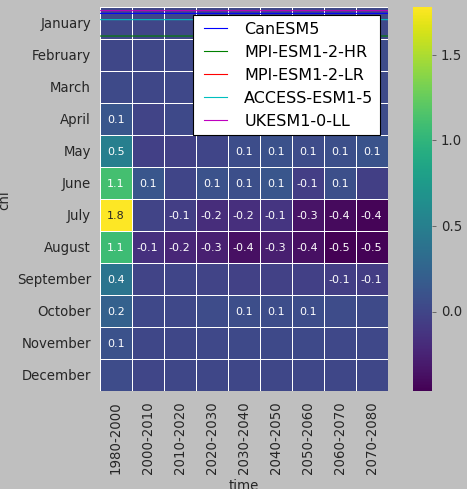

Working on LME: Barents Sea


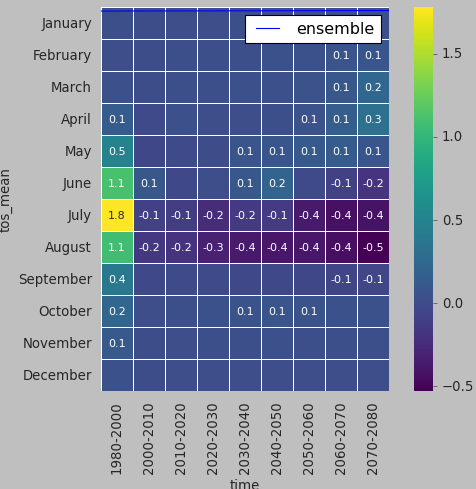

Working on LME: Barents Sea


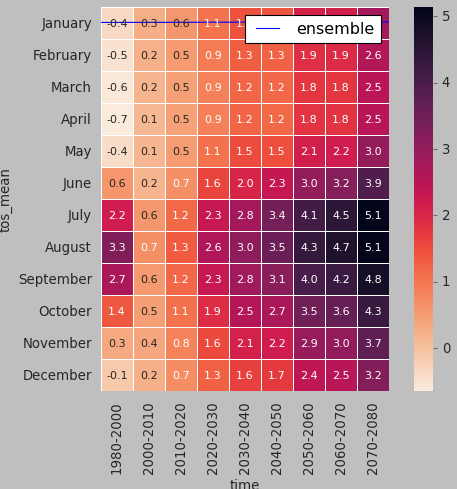

Working on LME: Northern Bering - Chukchi Seas


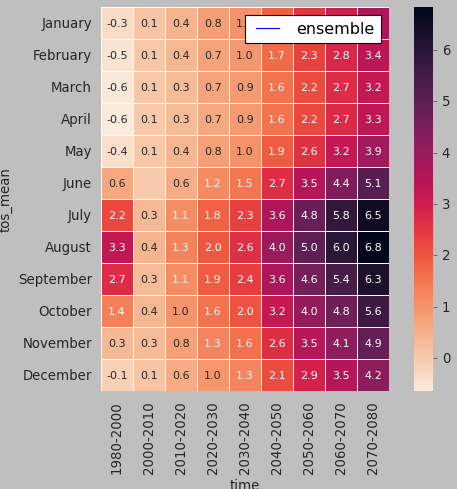

Working on LME: Northern Bering - Chukchi Seas


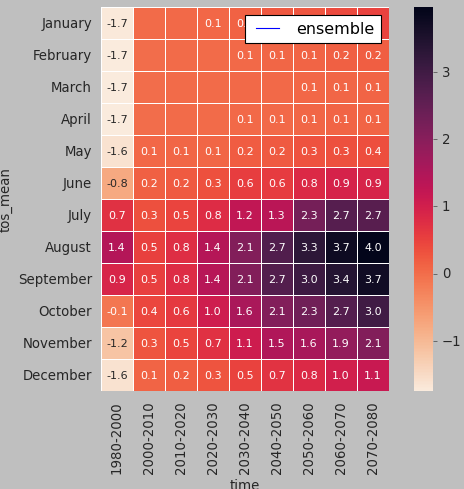

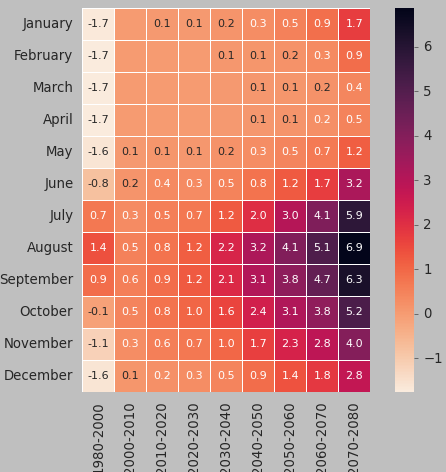

In [5]:
scenarios = ["ssp245", "ssp585"] #, "ssp585"]
member_range = 10
ensemble_ids = ["r{}i{}p{}f{}".format(str(i + 1), str(ii + 1), str(iii + 1), str(iv + 1)) for i in
                range(member_range)
                for ii in range(member_range) for iii in range(member_range) for iv in range(member_range)]

period = "1950-01-01-2099-12-16"
start_time = "1950-01-01"
end_time = "2099-12-16"

models = ["CanESM5", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "ACCESS-ESM1-5","UKESM1-0-LL"]
#models = ["CanESM5", "CMCC-ESM", "ACCESS-ESM1-5",  "MPI-ESM1-2-LR"]

# This script is created only to plot the seasonal mismatch in the
# future of chlorophyll.
ds_var_names = ["chl", "tos"]
seasonal=False
cumulative=False
LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']

for var_name in ds_var_names:
    for LME in LMES:
        df_list = []
        models_dict = {}
        # We loop over all scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:
            ds_list = []
            if var_name == "tos":
                fname=f"/Users/trondkr/Library/CloudStorage/OneDrive-ActeaInc/NIVA/oceanography/cmip6/light/tos" \
                     f"/tos_ensemble_{scenario}.nc"

                models_dict, ens_stats = get_area_averaged_ds(fname, "ensemble", scenario, "ensemble", "tos_mean",
                                                                       LME, models_dict)
            else:
                for model in models:
                    for ensemble_id in ensemble_ids:

                        base="/Users/trondkr/Library/CloudStorage/OneDrive-ActeaInc/NIVA/oceanography/cmip6/light"
                        fname = f"{base}/{scenario}/{model}/CMIP6_{model}_{ensemble_id}_{scenario}_{var_name}.nc"
                        key = f"{model}_{ensemble_id}_{scenario}_{var_name}"

                        if key not in models_dict.keys():
                            models_dict, ds_lme = get_area_averaged_ds(fname, model, scenario, ensemble_id, var_name,
                                                                           LME, models_dict)

                            if ds_lme is not None:
                                ds_list.append(ds_lme)

            if len(ds_list) > 0:
                ens = ensembles.create_ensemble(ds_list).load()
                ens_stats = ensembles.ensemble_mean_std_max_min(ens)

                outfile = f"Figures/{var_name}_ensemble_{scenario}_{LME}.png"

            if ens_stats is not None:

                # Create timeseries plots
                if var_name == "tos":
                    var_name_ens=f"{var_name}_mean"
                    sns.lineplot( x=ens_stats.time.resample(time="A").mean(),
                                      y=var_name_ens,
                                      data=ens_stats.mean({"lat","lon"}).resample(time="A").mean(),
                                      label=f"ensemble")

                else:
                    for model, ds in zip(models, ds_list):
                        sns.lineplot( x=ds.time.resample(time="A").mean(),
                                      y=var_name,
                                      data=ds.mean({"lat","lon"}).resample(time="A").mean(),
                                      label=f"{model}")
                    var_name_ens=f"{var_name}_mean"
                plt.legend()
                plt.show()
                plt.clf()
                # Create heatmaps
                df=ens_stats.to_dataframe().reset_index()
                start_times = [datetime(1980, 1, 1)]
                end_times = [datetime(2000, 1, 1)]

                step = 10
                # TODO: Add longer historical period by joining two lists.
                start_times.extend([datetime(2000+ i, 1, 1) for i in range(0,80, step)])

                end_times.extend([datetime(2000 + step + i, 1, 1) for i in range(0, 80, step)])

                labels = []
                dfs = []

                max_df_dict = {}
                if seasonal:
                    frequency = "season"
                else:
                    frequency = "month"

                for start, end in zip(start_times, end_times):
                    label=f"{start.year}-{end.year}"
                    labels.append(label)

                    df = CMIP6_ridgeplot.return_df_climatology(
                        var_name_ens,
                        None,
                        start_time=start,
                        end_time=end,
                        depth_threshold=None,
                        ds=ens_stats,
                        cumulative=cumulative,
                        seasonal=seasonal,
                    ).reset_index(level=frequency)

                    df.set_index('month', inplace=True)
                    dfs.append(df)
                    max_df_dict[label] = df[var_name_ens].groupby('month').mean()

                CMIP6_ridgeplot.heatmap_of_change(max_df_dict, var_name_ens, labels, 12, LME, scenario)
                """
                CMIP6_ridgeplot.ridgeplot(f"{var_name}_mean",
                                          None,
                                          outfile,
                                          glorys=False,
                                          depth_threshold=None,
                                          ds=ens_stats,
                                          cumulative=cumulative,
                                          seasonal=seasonal)
                """
        ds_list = []